In [1]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [2]:
train_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_17-33\large_data.csv")
test_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_17-33/test.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/with_decay/no_j/no_j_1000.csv")

# train_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100000.csv")
# test_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_10000.csv")
train_df.head()
print(len(train_df))

11000


In [3]:
class TrigonometricLayer(tf.keras.layers.Layer):
    def __init__(self, t, num_measurements, **kwargs):
        super(TrigonometricLayer, self).__init__(**kwargs)
        self.t = t  # Time at which measurements are taken
        self.num_measurements = num_measurements  # Number of measurement functions

    def build(self, input_shape):
        # Initialize trainable parameters

        self.trig_weights = self.add_weight(
            name='trig_weights',
            shape=(20, 8),
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=1.0),
            trainable=True
        )

        super(TrigonometricLayer, self).build(input_shape)


    def call(self, inputs):
        # Compute each measurement function based on trainable parameters
        w0, w1, j,a1, a2 = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3], inputs[:, 4]


        x1 = tf.cos(w0 *  self.t) * tf.exp(- a1 *  self.t)
        x2 = tf.cos(w1 *  self.t) * tf.exp(- a1 *  self.t)
        x3 = tf.cos(j *  self.t) * tf.exp(- a1 *  self.t)
        x4 = tf.sin(w0 *  self.t) * tf.exp(- a1 *  self.t)
        x5 = tf.sin(w1 *  self.t) * tf.exp(- a1 *  self.t)
        x6 = tf.sin(j *  self.t) * tf.exp(- a1 *  self.t)
        x7 = tf.cos((w0 +  w1) *  self.t) * tf.exp(- a1 *  self.t)
        x8 = tf.cos((w0 +  j) *  self.t) * tf.exp(- a1 *  self.t)
        x9 = tf.cos((w1 +  j) *  self.t) * tf.exp(- a1 *  self.t)
        x10 = tf.cos((w1 +  j +  w0) *  self.t) * tf.exp(- a1 *  self.t)

        x11 = tf.cos(w0 *  self.t) * tf.exp(- a2 *  self.t)
        x12 = tf.cos(w1 *  self.t) * tf.exp(- a2 *  self.t)
        x13 = tf.cos( j *  self.t) * tf.exp(- a2 *  self.t)
        x14 = tf.sin( w0 *  self.t) * tf.exp(- a2 *  self.t)
        x15 = tf.sin( w1 *  self.t) * tf.exp(- a2 *  self.t)
        x16 = tf.sin( j *  self.t) * tf.exp(- a2 *  self.t)
        x17 = tf.cos(( w0 +  w1) *  self.t) * tf.exp(- a2 *  self.t)
        x18 = tf.cos(( w0 +  j) *  self.t) * tf.exp(- a2 *  self.t)
        x19 = tf.cos(( w1 +  j) *  self.t) * tf.exp(- a2 *  self.t)
        x20 = tf.cos(( w1 +  j +  w0) *  self.t) * tf.exp(- a2 *  self.t)

        trig_combinations = tf.stack([
            x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
            x11, x12, x13, x14, x15, x16, x17, x18, x19, x20
        ], axis=-1)


        outputs = tf.matmul(trig_combinations, self.trig_weights)  # Shape: (1, num_features)

        return outputs

In [4]:
import tensorflow as tf

learning_rate = 0.0001
epochs = 50
batch_size = 100

# Get all column names as a list
keys = train_df.keys().tolist()
input_keys = ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]

output_keys = [key for key in keys if key not in input_keys]

inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in input_keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))




# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]

def build_model(input_layer, num_layers, nodes_per_layer=None, default_nodes=64):
    # If no list of nodes is provided, use the default number of nodes for all layers
    if nodes_per_layer is None:
        nodes_per_layer = [default_nodes] * num_layers

    # Check if nodes_per_layer has the correct number of layers
    assert len(nodes_per_layer) == num_layers, "Length of nodes_per_layer must match num_layers"

    # Build the hidden layers dynamically
    hidden_layer = input_layer
    for i in range(num_layers):
        hidden_layer = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(hidden_layer)

    # Output layer (Assuming len(output_keys) is predefined)
    output = tf.keras.layers.Dense(len(output_keys))(hidden_layer)

    return output


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = build_model(concatenated_inputs, len(nodes_per_layer), nodes_per_layer)


model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [5]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2387 - val_loss: 0.2218
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2194 - val_loss: 0.2091
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2060 - val_loss: 0.1979
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 - val_loss: 0.1861
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1841 - val_loss: 0.1743
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1721 - val_loss: 0.1627
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1609 - val_loss: 0.1512
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1491 - val_loss: 0.1401
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 - val_loss: 0.1296
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1267 - val_loss: 0.1196
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1176 - val_loss: 0.1104
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1083 - val_lo

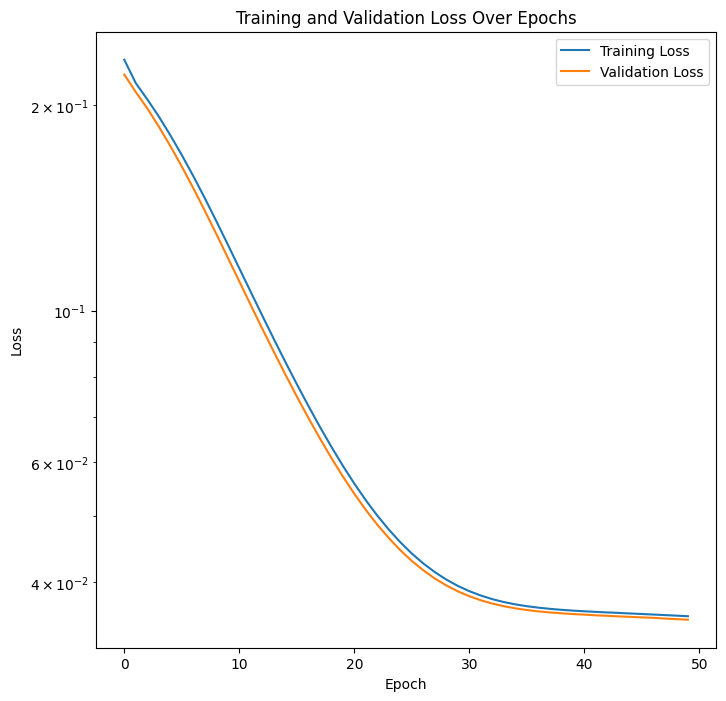

In [6]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [8]:
import numpy as np
import estimator
new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[5]
correct_output = first_line[output_keys].array

input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)



parameters = {key: np.array([first_line[key]]) for key in input_keys}
print(parameters)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted values:  [0.20470507 0.19124465 0.2715865  0.297127   0.2236169  0.15327507
 0.22191538 0.16737773]
Correct values:  <PandasArray>
[0.4368, 0.368, 0.4368, 0.368, 0.6392, 0.3616, 0.6392, 0.3616]
Length: 8, dtype: float64
the mean squared error is:  0.16361589754224712
The percent error is:  120.68077950508254
{'decay_0': array([1.6047673]), 'decay_1': array([0.64881887]), 'W_0': array([-1.94145595]), 'W_1': array([-2.52619279]), 'J_0': array([-0.62497355])}


In [9]:
import tensorflow as tf

# Assuming `model` is your trained model and `output_keys` is defined
# Define the target output values you want to achieve
target_outputs = tf.constant(correct_output,dtype=tf.float32)  # Replace with your target values

# Initialize the input parameters as variables to optimize
initial_guess = {
    'decay_0': 0.5,
    'decay_1': 0.5,
    'W_0': 0,
    'W_1': 0,
    'J_0': 0
}
input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}

# Use the variables as inputs to the model
def model_loss():
    # Pass the variables through the model to get the predicted output
    model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
    predicted_outputs = model(model_inputs, training=False)

    # Calculate the loss between predicted and target outputs
    loss = tf.reduce_mean(tf.square(predicted_outputs - target_outputs))
    return loss

# Set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Optimization loop
for step in range(1000):  # Adjust the number of steps as needed
    with tf.GradientTape() as tape:
        loss = model_loss()

    # Compute the gradients of the loss with respect to the input variables
    grads = tape.gradient(loss, input_vars.values())

    # Apply the gradients to the input variables
    optimizer.apply_gradients(zip(grads, input_vars.values()))

    # Print the loss and current input variables every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")

# Final optimized input parameters
optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}
print("Optimized Inputs:", optimized_inputs)
print(parameters)

Step 0, Loss: 0.2511776089668274, Inputs: [0.5099994, 0.5099995, -0.009999234, -0.009999459, -0.009998875]
Step 100, Loss: 0.10854057967662811, Inputs: [1.2116598, 1.402986, -0.89714944, -0.83214456, -0.06861462]
Step 200, Loss: 0.08050929754972458, Inputs: [1.5020462, 1.9721491, -1.389115, -1.246755, -0.09936407]
Step 300, Loss: 0.07033027708530426, Inputs: [1.6729777, 2.2239807, -1.8570586, -1.5870671, -0.025808083]
Step 400, Loss: 0.06839902698993683, Inputs: [1.7443633, 2.2934403, -2.1148505, -1.740051, 0.009613622]
Step 500, Loss: 0.06827262789011002, Inputs: [1.771847, 2.3042688, -2.180693, -1.7861588, 0.0056858812]
Step 600, Loss: 0.06826271116733551, Inputs: [1.7847601, 2.29986, -2.1914558, -1.7981579, -0.010703719]
Step 700, Loss: 0.06825760751962662, Inputs: [1.7953331, 2.2910147, -2.1904142, -1.8032668, -0.02865728]
Step 800, Loss: 0.06825151294469833, Inputs: [1.8070005, 2.2795172, -2.1853034, -1.8079401, -0.04674983]
Step 900, Loss: 0.0682450532913208, Inputs: [1.8196267, 

In [ ]:
import estimator

In [28]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[10]
correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

AttributeError: module 'sympy' has no attribute 'assumptions'

In [118]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [119]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  56.559793507707965


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 